In this notebook the validity of combined synthetic data will be measured. Combined data has been created by combining the synthetic data generated by models trained on the top 5 service code descriptions for 200 epochs.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sdv.single_table import CTGANSynthesizer
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")


Libraries imported successfully!


In [2]:
# Load all trained models from checkpoints_3/models
models_dir = Path("checkpoints_3/models")
model_files = list(models_dir.glob("*.pkl"))

print(f"Found {len(model_files)} model files:")
for file in model_files:
    print(f"  - {file.name}")

# Load each model
models = {}
service_codes = []

for model_file in tqdm(model_files, desc="Loading models"):
    # Extract service code from filename (remove '_final.pkl')
    service_code = model_file.stem.replace('_final', '')
    service_codes.append(service_code)
    
    print(f"\nLoading model for: {service_code}")
    model = CTGANSynthesizer.load(str(model_file))
    models[service_code] = model
    print(f"✓ Model loaded successfully")

print(f"\n✓ All {len(models)} models loaded successfully!")
print(f"Service codes: {service_codes}")


Found 5 model files:
  - ASSIST MEMBER OF THE PUBLIC_final.pkl
  - THEFT_final.pkl
  - DOMESTIC INCIDENT_final.pkl
  - CONCERN FOR PERSON_final.pkl
  - DISTURBANCE_final.pkl


Loading models:   0%|          | 0/5 [00:00<?, ?it/s]


Loading model for: ASSIST MEMBER OF THE PUBLIC
✓ Model loaded successfully

Loading model for: THEFT
✓ Model loaded successfully

Loading model for: DOMESTIC INCIDENT
✓ Model loaded successfully

Loading model for: CONCERN FOR PERSON
✓ Model loaded successfully

Loading model for: DISTURBANCE
✓ Model loaded successfully

✓ All 5 models loaded successfully!
Service codes: ['ASSIST MEMBER OF THE PUBLIC', 'THEFT', 'DOMESTIC INCIDENT', 'CONCERN FOR PERSON', 'DISTURBANCE']


In [3]:
# Load original filtered data to understand the data structure and proportions
original_data_path = "filtered_data/df_v2_filtered.pkl"
df_original = pd.read_pickle(original_data_path)

print(f"Original dataset shape: {df_original.shape}")
print(f"Columns: {list(df_original.columns)}")

# Get the distribution of service codes in the original data
service_code_counts = df_original["service_code_description"].value_counts()
top_5_counts = service_code_counts.head(5)

print(f"\nTop 5 service code distributions in original data:")
for code, count in top_5_counts.items():
    percentage = (count / len(df_original)) * 100
    print(f"  {code}: {count:,} records ({percentage:.1f}%)")

print(f"\nTotal records in top 5 categories: {top_5_counts.sum():,}")
print(f"Percentage of total data: {(top_5_counts.sum() / len(df_original)) * 100:.1f}%")


Original dataset shape: (1340347, 7)
Columns: ['hour_created', 'max_final_priority', 'inc_resourced', 'scrs_crime_inc', 'service_code_description', 'multi_member_ward', 'date_seq']

Top 5 service code distributions in original data:
  ASSIST MEMBER OF THE PUBLIC: 169,406 records (12.6%)
  CONCERN FOR PERSON: 121,876 records (9.1%)
  DISTURBANCE: 90,395 records (6.7%)
  THEFT: 87,517 records (6.5%)
  DOMESTIC INCIDENT: 79,291 records (5.9%)

Total records in top 5 categories: 548,485
Percentage of total data: 40.9%


In [4]:
# Generating slice synthetic data
synthetic_slices = []

# Generating slice synthetic data
for service, count in top_5_counts.items():
    # derive model key from the service description
    model = models.get(service)
    if model is None:
        print(f"Warning: no model for '{service}' (key='{key}'), skipping.")
        continue

    # sample exactly `count` rows
    print(f"Generating {count} samples for '{service}'...")
    slice_df = model.sample(count)

    # tag the synthetic rows with their service code
    slice_df["service_code_description"] = service

    # collect for later concatenation
    synthetic_slices.append(slice_df)

Generating 169406 samples for 'ASSIST MEMBER OF THE PUBLIC'...
Generating 121876 samples for 'CONCERN FOR PERSON'...
Generating 90395 samples for 'DISTURBANCE'...
Generating 87517 samples for 'THEFT'...
Generating 79291 samples for 'DOMESTIC INCIDENT'...


In [5]:
df_top5_synth = pd.concat(synthetic_slices, ignore_index=True)
print(f"Created synthetic slice for top 5 with {len(df_top5_synth)} rows.")

service_code_counts = df_original["service_code_description"].value_counts()
top5 = service_code_counts.head(5).index.tolist()
df_top5_real = df_original[df_original["service_code_description"].isin(top5)].copy()

print(f"Filtered dataset shape (top 5 only): {df_top5_real.shape}")
print("Remaining categories:", df_top5_real["service_code_description"].unique().tolist())

Created synthetic slice for top 5 with 548485 rows.
Filtered dataset shape (top 5 only): (548485, 7)
Remaining categories: ['THEFT', 'ASSIST MEMBER OF THE PUBLIC', 'CONCERN FOR PERSON', 'DISTURBANCE', 'DOMESTIC INCIDENT']


In [6]:
df_top5_real.dtypes

hour_created                 int32
max_final_priority          object
inc_resourced               object
scrs_crime_inc              object
service_code_description    object
multi_member_ward           object
date_seq                     int64
dtype: object

## Diagnostic Metrics

These metrics are not really informative. Data Structure measures whether the synthetic data captures the same table structure as the real data. We expect the synthetic data to have the same column names as the real data, and for those columns to have the same data storage type (ints, strings, etc.).

In [32]:
from sdmetrics.reports.single_table import DiagnosticReport
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Generate the diagnostic report
report = DiagnosticReport()
report.generate(dft, synthetic_data, metadata['tables']['incidents'])

# Get the overall diagnostic score (between 0 and 1)
overall_score = report.get_score()
print(f"Overall diagnostic score: {overall_score}")

# Get the individual property scores
properties = report.get_properties()
print("Property scores:", properties)

# Get detailed scores for 'Data Validity'
details_validity = report.get_details(property_name='Data Validity')
print("Data Validity Details:\n", details_validity)

# Get detailed scores for 'Data Structure'
details_structure = report.get_details(property_name='Data Structure')
print("Data Structure Details:\n", details_structure)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 7/7 [00:00<00:00, 72.99it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 832.04it/s]|
Data Structure Score: 16.67%

Overall Score (Average): 58.33%

Overall diagnostic score: 0.5833333333333334
Property scores:          Property     Score
0   Data Validity  1.000000
1  Data Structure  0.166667
Data Validity Details:
                      Column             Metric  Score
0              hour_created  BoundaryAdherence    1.0
1        max_final_priority  CategoryAdherence    1.0
2             inc_resourced  CategoryAdherence    1.0
3            scrs_crime_inc  CategoryAdherence    1.0
4         multi_member_ward  CategoryAdherence    1.0
5  service_code_description  CategoryAdherence    1.0
6                  date_seq  BoundaryAdherence    1.0
Data Structure Details:
            Metric     Score
0  TableStructure  0.166667


## Utility

### Hellingers Distance

In [7]:
dft_copy = df_top5_real.copy()
synthetic_data_copy = df_top5_synth.copy()

In [30]:
# Changing datatype from object -> category
object_cols = synthetic_data_copy.select_dtypes(include='object').columns
synthetic_data_copy[object_cols] = synthetic_data_copy[object_cols].astype('category')

In [31]:
## Hellingers Distance
import numpy as np
from collections import Counter

def hellinger_categorical(a, b):
    counter_a = Counter(a)
    counter_b = Counter(b)
    all_keys = set(counter_a) | set(counter_b)
    total_a, total_b = len(a), len(b)
    p = np.array([counter_a.get(k, 0)/total_a for k in all_keys])
    q = np.array([counter_b.get(k, 0)/total_b for k in all_keys])
    return np.linalg.norm(np.sqrt(p) - np.sqrt(q)) / np.sqrt(2)

def hellinger_numerical(a, b, bins=10):
    counts_a, edges = np.histogram(a, bins=bins, density=True)
    counts_b, _ = np.histogram(b, bins=edges, density=True)
    p = counts_a / counts_a.sum()
    q = counts_b / counts_b.sum()
    return np.linalg.norm(np.sqrt(p) - np.sqrt(q)) / np.sqrt(2)

In [32]:
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

def hellinger(p, q):
    # Normalize to probability distributions
    p = np.asarray(p, dtype=np.float64)
    q = np.asarray(q, dtype=np.float64)
    p = p / p.sum()
    q = q / q.sum()
    return np.linalg.norm(np.sqrt(p) - np.sqrt(q)) / np.sqrt(2)

def compare_columns(real: pd.DataFrame, synth: pd.DataFrame, bins=10):
    distances = {}
    for col in real.columns:
        if real[col].dtype == 'object' or pd.api.types.is_categorical_dtype(real[col]):
            # Categorical column
            categories = list(set(real[col].unique()) | set(synth[col].unique()))
            real_counts = real[col].value_counts(normalize=True).reindex(categories, fill_value=0)
            synth_counts = synth[col].value_counts(normalize=True).reindex(categories, fill_value=0)
            dist = hellinger(real_counts.values, synth_counts.values)
        else:
            # Numerical column
            col_min = min(real[col].min(), synth[col].min())
            col_max = max(real[col].max(), synth[col].max())
            bin_edges = np.linspace(col_min, col_max, bins + 1)
            real_hist, _ = np.histogram(real[col], bins=bin_edges)
            synth_hist, _ = np.histogram(synth[col], bins=bin_edges)
            dist = hellinger(real_hist, synth_hist)
        distances[col] = dist
    return distances
    
results = compare_columns(dft_copy, synthetic_data_copy, bins=10)

In [33]:
for key,val in results.items():
    print(f"{key}:{val}")

hour_created:0.060441151731394464
max_final_priority:0.030513851805819774
inc_resourced:0.037947054097569044
scrs_crime_inc:6.182943529089418e-05
service_code_description:0.0
multi_member_ward:0.06372288773541095
date_seq:0.06429426186463448


In [34]:
## Why multivariate hellingers distance is not feasible to caluclate
cols = dft_copy.columns
real_tuples = list(map(tuple, dft_copy[cols].astype(str).values))
synth_tuples = list(map(tuple, synthetic_data_copy[cols].astype(str).values))
# All possible bins encountered in either dataset
all_bins = list(set(real_tuples) | set(synth_tuples))

# number of column combination for evaluating the multivariate distribution
len(all_bins)

1068679

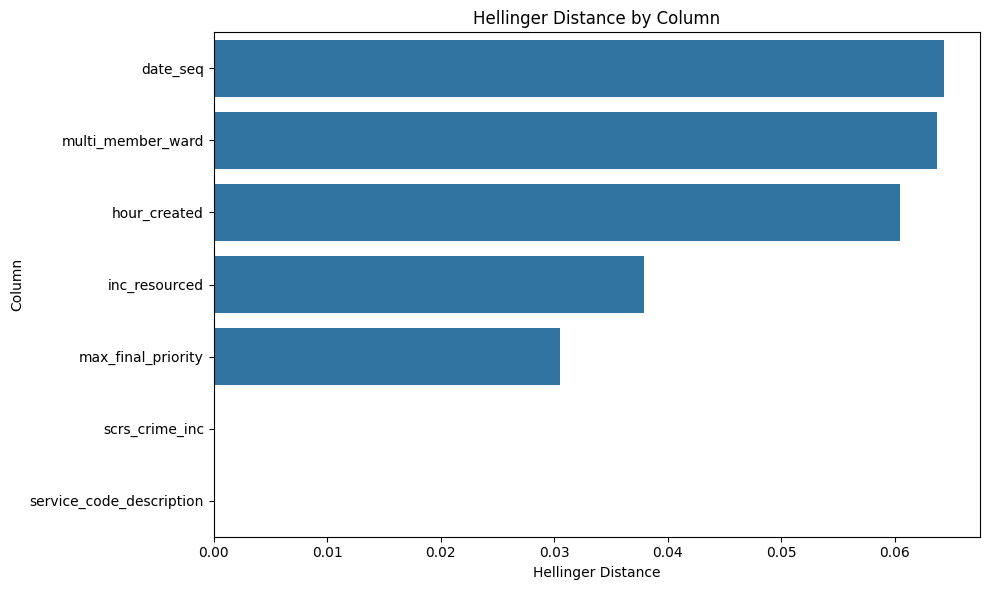

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert results dict to DataFrame
df_dist = (
    pd.DataFrame(results.items(), columns=['column', 'hellinger_distance'])
      .sort_values('hellinger_distance', ascending=False)
)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_dist, x='hellinger_distance', y='column')
plt.title('Hellinger Distance by Column')
plt.xlabel('Hellinger Distance')
plt.ylabel('Column')
plt.tight_layout()
plt.show()


### TSTR

In [3]:
# loading data
import pandas as pd

df_filtered = pd.read_pickle("filtered_data/df_v2_filtered.pkl")

In [4]:
from sklearn.model_selection import train_test_split

# Split into 80% train and 20% test
train_df, test_df = train_test_split(df_filtered, test_size=0.2, random_state=42)

# Reset indices
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [5]:
total = len(df_filtered)
print("Train set size:", len(train_df), f"({len(train_df)/total:.1%})")
print("Test set size:", len(test_df), f"({len(test_df)/total:.1%})")

Train set size: 1072277 (80.0%)
Test set size: 268070 (20.0%)


In [6]:
from sdv.metadata import Metadata

# 1. auto-detect metadata based in your data
metadata = Metadata.detect_from_dataframes({"incidents":train_df})

# 2. carefully inspect and update your metadata
metadata.visualize()

metadata.validate()

# 3. when you're done, save it to a file for future use
# metadata.save_to_json('my_final_metadata_tstr.json')

In [ ]:
from sdv.single_table import CTGANSynthesizer
ctgan = CTGANSynthesizer(
    metadata,
    epochs=800,
    batch_size=1024,
    pac=8,
    embedding_dim=128,
    generator_dim=(256, 256),
    discriminator_dim=(256, 256),
    generator_lr=2e-4,
    discriminator_lr=2e-4,
    cuda=True,
    verbose=True
)
ctgan.fit(train_df)   

/dcs/large/u2164966/MSc_Dissertation/myenv/lib64/python3.12/site-packages/sdv/single_table/base.py:128: UserWarning:

We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.

/dcs/large/u2164966/MSc_Dissertation/myenv/lib64/python3.12/site-packages/sdv/single_table/ctgan.py:252: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [ ]:
syn_df = ctgan.sample(len(train_df))

In [ ]:
# Saving the model to a pickle file
ctgan.save(
    filepath='models/ctgan_theft_v8_800epochs_tsrt.pkl'
)

In [ ]:
target_col = 'inc_resourced'                       # ❸ rename to your real target
categorical_cols = [
    col for col in syn_df.columns
    if (syn_df[col].dtype == 'object' or syn_df[col].dtype.name == 'category')
       and col != target_col
]

# Ensure every categorical column is pandas "category" dtype in **both** sets
for col in categorical_cols:
    combined = pd.concat([syn_df[col], test_df[col]], axis=0)
    unified  = pd.Categorical(combined)
    syn_df[col]  = unified[:len(syn_df)].astype('category')
    test_df[col] = unified[len(syn_df):].astype('category')

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, f1_score,
    classification_report, confusion_matrix
)

X_syn   = syn_df.drop(columns=[target_col])
y_syn   = syn_df[target_col]

X_test  = test_df.drop(columns=[target_col])
y_test  = test_df[target_col]

lgbm = LGBMClassifier(
    objective='bianary',
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=64,
    random_state=42
)

In [ ]:
lgbm.fit(
    X_syn, y_syn,
    categorical_feature=categorical_cols
)

In [ ]:
y_pred       = lgbm.predict(X_test)
y_pred_proba = lgbm.predict_proba(X_test)[:, 1]

print("=== TSTR evaluation (train: synthetic, test: real) ===")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("ROC-AUC  :", roc_auc_score(y_test, y_pred_proba))
print("F1-score :", f1_score(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nDetailed report:\n", classification_report(y_test, y_pred))

## Fidelity

In [36]:
# Creating copies of dfs
dft_copy = df_top5_real.copy()
synthetic_data_copy = df_top5_synth.copy()

dft_copy["is_real"]          = 1        # positive class
synthetic_data_copy["is_real"] = 0        # negative class

full = pd.concat([dft_copy, synthetic_data_copy], ignore_index=True)

In [37]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split

# Assuming 'full' is your combined DataFrame from the prompt

# Define features (X) and target (y)
X = full.drop('is_real', axis=1)
y = full['is_real']

# Convert object columns to the 'category' dtype for LightGBM
for col in X.select_dtypes(include='object').columns:
    X[col] = X[col].astype('category')

# Split data for training and testing the classifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Initialize and train the LightGBM classifier
lgbm = lgb.LGBMClassifier(objective='binary', random_state=42)
lgbm.fit(X_train, y_train)

# Get propensity scores for the entire dataset
# The [:, 1] selects the probability of the positive class (is_real=1)
full['p_score'] = lgbm.predict_proba(X)[:, 1]

# Display the scores for real vs. synthetic data
print(full.groupby('is_real')['p_score'].describe())

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 383940, number of negative: 383939
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 767879, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500001 -> initscore=0.000003
[LightGBM] [Info] Start training from score 0.000003
            count      mean       std       min       25%       50%       75%  \
is_real                                                                         
0        548485.0  0.431805  0.166690  0.003390  0

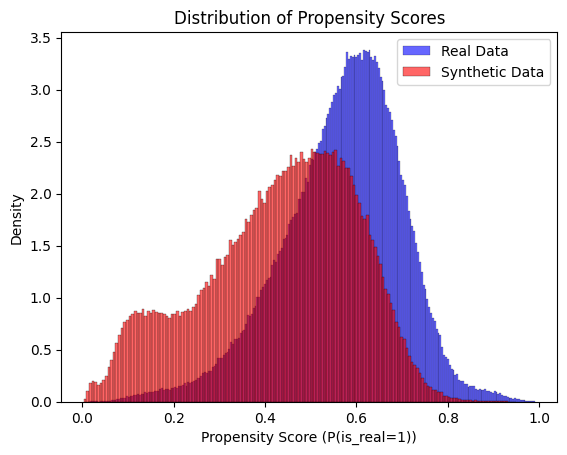

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Separate the scores for real and synthetic data
real_scores = full[full['is_real'] == 1]['p_score']
synthetic_scores = full[full['is_real'] == 0]['p_score']

# Plot the distributions
sns.histplot(real_scores, color="blue", label='Real Data', stat='density', alpha=0.6)
sns.histplot(synthetic_scores, color="red", label='Synthetic Data', stat='density', alpha=0.6)

plt.legend()
plt.title('Distribution of Propensity Scores')
plt.xlabel('Propensity Score (P(is_real=1))')
plt.show()

### Other Metrics

1. Dropped service_code_desc in suspicion that it migh misrepresent
2. Switched to an unbiased MMD² estimator (excluded the diagonal entries for the same reason)

In [44]:
# -----------------------------------------------------------------------
# 0.  Imports
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.metrics.pairwise import pairwise_kernels, pairwise_distances

from scipy.spatial.distance import jensenshannon

from sdmetrics.reports.single_table import QualityReport
from sdv.metadata import SingleTableMetadata

# -----------------------------------------------------------------------
# 1.  Helper: Unbiased Maximum Mean Discrepancy (Gaussian kernel, median heuristic)
# -----------------------------------------------------------------------
def _mmd2_gaussian_unbiased(X, Y, subsample=None):
    """
    Unbiased estimate of MMD² between X and Y with an RBF kernel.
    """
    rng = np.random.default_rng(42)
    if subsample and (len(X) > subsample):
        X = X[rng.choice(len(X), subsample, replace=False)]
    if subsample and (len(Y) > subsample):
        Y = Y[rng.choice(len(Y), subsample, replace=False)]

    # pairwise RBF kernel matrices
    # median heuristic for gamma
    Z = np.vstack([X, Y])
    dists = pairwise_distances(Z, metric='euclidean')
    gamma = 1.0 / (2.0 * np.median(dists[dists > 0]) ** 2)

    Kxx = pairwise_kernels(X, X, metric='rbf', gamma=gamma)
    Kyy = pairwise_kernels(Y, Y, metric='rbf', gamma=gamma)
    Kxy = pairwise_kernels(X, Y, metric='rbf', gamma=gamma)

    n, m = X.shape[0], Y.shape[0]
    sum_Kxx = (Kxx.sum() - np.trace(Kxx)) / (n * (n - 1))
    sum_Kyy = (Kyy.sum() - np.trace(Kyy)) / (m * (m - 1))
    sum_Kxy = Kxy.mean()  # cross terms exclude self-similarities

    return sum_Kxx + sum_Kyy - 2 * sum_Kxy

# -----------------------------------------------------------------------
# 2.  Prepare numeric matrix for MMD (encode categoricals, scale 0-1)
# -----------------------------------------------------------------------
def _prep_for_mmd(df, cat_cols):
    num_cols = [c for c in df.columns if c not in cat_cols]
    enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    df_enc = df.copy()

    if cat_cols:
        df_enc[cat_cols] = enc.fit_transform(df[cat_cols])

    scaler = MinMaxScaler()
    df_enc[num_cols + cat_cols] = scaler.fit_transform(df_enc[num_cols + cat_cols])
    return df_enc[num_cols + cat_cols].to_numpy()

# -----------------------------------------------------------------------
# 3.  Exclude label column from evaluation
# -----------------------------------------------------------------------
label_col = 'service_code_description'
eval_cols = [c for c in df_top5_real.columns if c != label_col]

# Identify categorical columns within eval_cols
cat_cols = [
    c for c in eval_cols
    if df_top5_real[c].dtype == 'object' or str(df_top5_real[c].dtype).startswith('category')
]

# Prepare matrices
X_real  = _prep_for_mmd(df_top5_real[eval_cols], cat_cols)
X_synth = _prep_for_mmd(df_top5_synth[eval_cols], cat_cols)

# Compute unbiased MMD²
mmd2 = _mmd2_gaussian_unbiased(X_real, X_synth, subsample=20000)
print(f"✅  Unbiased MMD² = {mmd2:.6f}   (lower → closer)")

# -----------------------------------------------------------------------
# 4.  Jensen–Shannon divergence – per column, then average (exclude label)
# -----------------------------------------------------------------------
def _js_col(real_col, synth_col, bins=30):
    if pd.api.types.is_numeric_dtype(real_col):
        hist_r, bin_edges = np.histogram(real_col, bins=bins, density=True)
        hist_s, _         = np.histogram(synth_col, bins=bin_edges, density=True)
    else:
        cats    = pd.Series(list(set(real_col) | set(synth_col)))
        hist_r  = real_col.value_counts(normalize=True).reindex(cats, fill_value=0).values
        hist_s  = synth_col.value_counts(normalize=True).reindex(cats, fill_value=0).values
    return jensenshannon(hist_r, hist_s, base=2) ** 2

js_scores = {
    col: _js_col(df_top5_real[col], df_top5_synth[col])
    for col in eval_cols
}
mean_js = np.mean(list(js_scores.values()))
print(f"✅  Jensen–Shannon divergence (mean over columns) = {mean_js:.6f}")

# -----------------------------------------------------------------------
# 5.  SDMetrics QualityReport
# -----------------------------------------------------------------------
# Auto-detect metadata from the real DataFrame
auto_meta = SingleTableMetadata()
auto_meta.detect_from_dataframe(df_top5_real[eval_cols])
metadata_dict = auto_meta.to_dict()

qr = QualityReport()
qr.generate(
    real_data=df_top5_real[eval_cols],
    synthetic_data=df_top5_synth[eval_cols],
    metadata=metadata_dict
)

quality_score = qr.get_score()
print(f"✅  SDMetrics QualityReport overall score = {quality_score:.3f}")

# Optional: per-column shape details
shape_details = qr.get_details(property_name='Column Shapes')
print(shape_details[['Column', 'Metric', 'Score']].head())

✅  Unbiased MMD² = 0.002589   (lower → closer)
✅  Jensen–Shannon divergence (mean over columns) = 0.004944
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 6/6 [00:00<00:00,  7.71it/s]|
Column Shapes Score: 95.33%

(2/2) Evaluating Column Pair Trends: |██████████| 15/15 [00:00<00:00, 19.40it/s]|
Column Pair Trends Score: 90.06%

Overall Score (Average): 92.69%

✅  SDMetrics QualityReport overall score = 0.927
               Column        Metric     Score
0        hour_created  KSComplement  0.924756
1  max_final_priority  TVComplement  0.969935
2       inc_resourced  TVComplement  0.958735
3      scrs_crime_inc  TVComplement  0.999922
4   multi_member_ward  TVComplement  0.936609


## Heat Map

In [6]:
# loading lookup file
lookup = pd.read_csv('DataZone2011lookup_2024-12-16.csv', encoding='latin1')
import unicodedata

# Function to normalize multi_member_ward values
def normalize_ward_name(name):
    if pd.isnull(name):
        return name
    name = unicodedata.normalize("NFKD", name).encode("ascii", "ignore").decode("utf-8")
    name = name.replace("&", "and").replace("/", ",").replace("'", "").strip()
    name = ' '.join(name.split())  # remove extra internal spaces
    return name.lower()  # optional: lowercase for consistency

# Apply to real dataset before training
lookup["MMWard_Name"] = lookup["MMWard_Name"].map(normalize_ward_name)

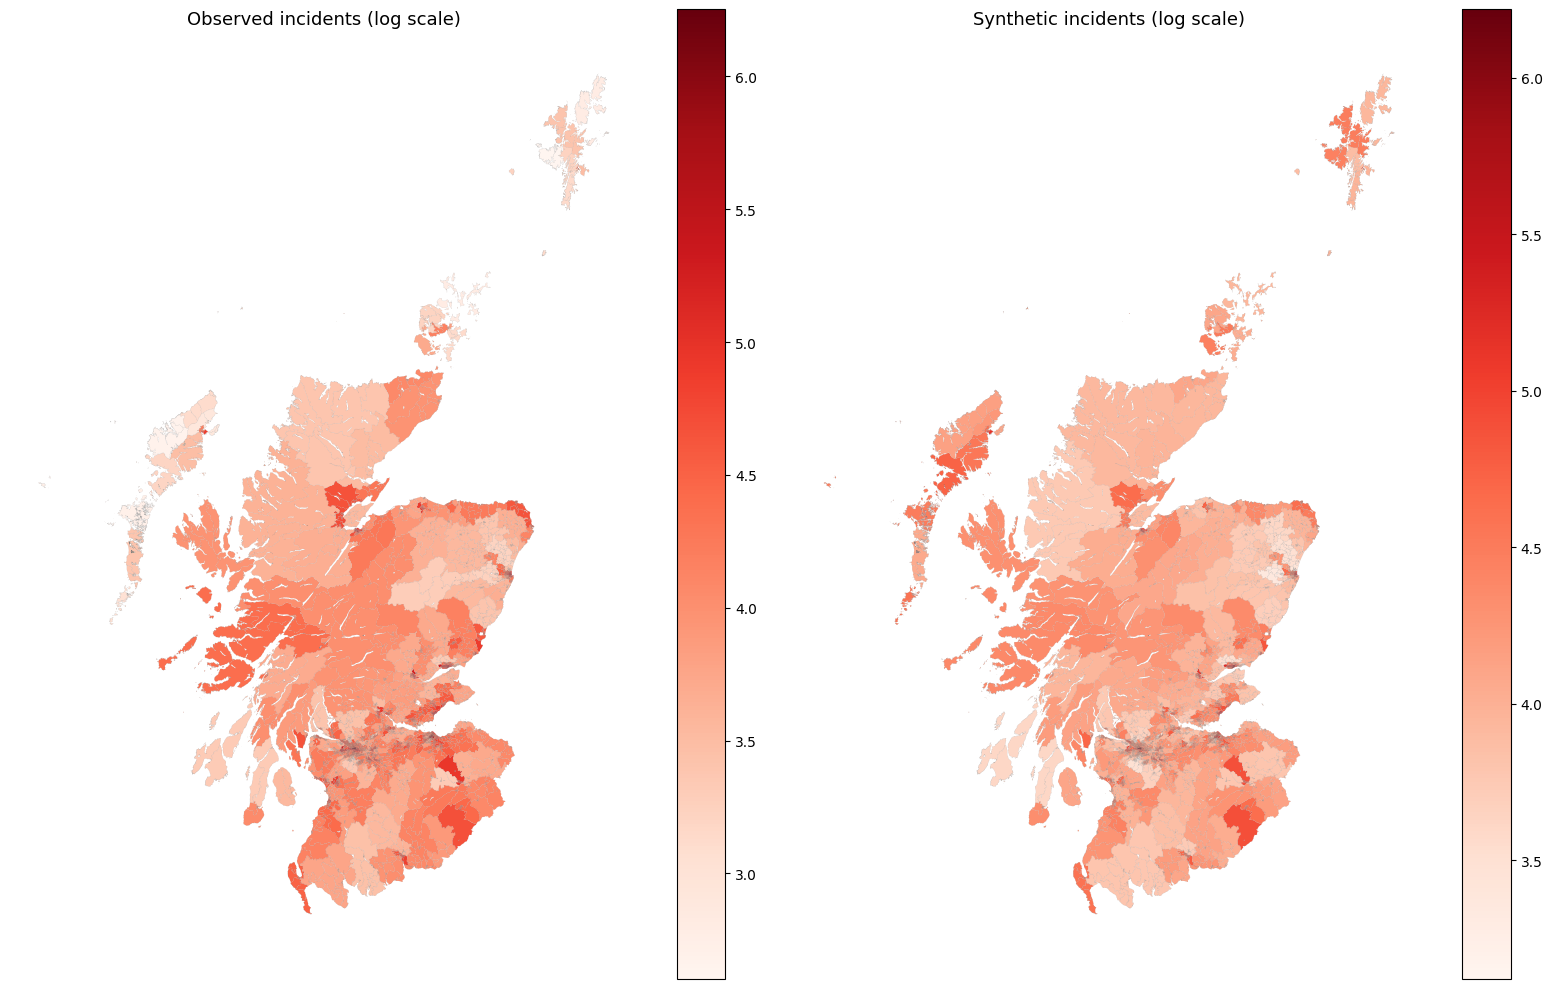

In [7]:
# ───────────────────────────  0.  HOUSEKEEPING  ───────────────────────────
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from rapidfuzz import process, fuzz
import unicodedata

# If your lookup hasn’t been renamed yet, do it once:
lookup = (lookup
          .rename(columns={"DZ2011_Code": "DataZone"})        # <-- change only if needed
          [["DataZone", "MMWard_Name"]])                      # keep essentials

# ───────────────────────  0.1  FUZZY WARD NAME MATCHING  ───────────────────────

# Helper to normalize ward names (lowercase, remove accents, clean symbols)
def normalize_ward_name(name: str) -> str:
    if pd.isnull(name):
        return ''
    name = unicodedata.normalize("NFKD", name).encode("ascii", "ignore").decode()
    name = name.replace("&", "and").replace("/", ",").replace("'", "").lower()
    return ' '.join(name.split()).strip()

# Build a dictionary of cleaned → original ward names from real data
real_wards = df_top5_real['multi_member_ward'].dropna().unique()
real_clean = {normalize_ward_name(name): name for name in real_wards}

# Map each synthetic ward name to the closest real one using fuzzy matching
def match_ward(name):
    cleaned = normalize_ward_name(name)
    match, score, _ = process.extractOne(cleaned, real_clean.keys(), scorer=fuzz.token_sort_ratio)
    return real_clean[match] if score > 85 else name  # Threshold can be adjusted

# Apply fuzzy mapping to synthetic data
df_top5_synth["multi_member_ward"] = df_top5_synth["multi_member_ward"].map(match_ward)

# ───────────────────────────  1.  WARD-LEVEL COUNTS  ───────────────────────────
for frame in (df_top5_real, df_top5_synth):
    frame["incident_count"] = 1                               # one incident per row

obs_ward = (df_top5_real
            .groupby("multi_member_ward", as_index=False)["incident_count"]
            .sum()
            .rename(columns={"multi_member_ward": "MMWard_Name",
                             "incident_count": "ward_incidents"}))

syn_ward = (df_top5_synth
            .groupby("multi_member_ward", as_index=False)["incident_count"]
            .sum()
            .rename(columns={"multi_member_ward": "MMWard_Name",
                             "incident_count": "ward_incidents"}))

# ───────────────────────────  2.  EXPAND TO DATA-ZONE  ───────────────────────────
dz_per_ward = (lookup
               .groupby("MMWard_Name")
               .size()
               .rename("n_dz")
               .reset_index())

def expand_to_dz(ward_counts: pd.DataFrame) -> pd.DataFrame:
    out = (ward_counts
           .merge(lookup, on="MMWard_Name", how="left")       # duplicate per DZ
           .merge(dz_per_ward, on="MMWard_Name", how="left"))
    out["dz_incidents"] = out["ward_incidents"] / out["n_dz"] # uniform share
    return out[["DataZone", "dz_incidents"]]

obs_dz = expand_to_dz(obs_ward)
syn_dz = expand_to_dz(syn_ward)

# ───────────────────────────  3.  LOAD & RENAME SHAPEFILE  ───────────────────────────
shp_path = "shape_files/SG_DataZone_Bdry_2011.shp"

# Print once to discover the real DZ column name, if unsure:
# print(gpd.read_file(shp_path, rows=0).columns)

shp = (gpd.read_file(shp_path)
       .rename(columns={"DZ_CODE": "DataZone"})                # CHANGE 'DZ_CODE' if needed
       .to_crs(epsg=4326))

# ───────────────────────────  4.  JOIN COUNTS → POLYGONS  ───────────────────────────
def attach_counts(gdf_base: gpd.GeoDataFrame,
                  dz_counts: pd.DataFrame) -> gpd.GeoDataFrame:
    gdf = (gdf_base.merge(dz_counts, on="DataZone", how="left")
                    .fillna({"dz_incidents": 0}))
    gdf["log_inc"] = np.log1p(gdf["dz_incidents"])             # log(x+1)
    return gdf

gdf_obs = attach_counts(shp, obs_dz)
gdf_syn = attach_counts(shp, syn_dz)

# ───────────────────────────  5.  PLOT SIDE-BY-SIDE  ───────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(16, 10), sharex=True, sharey=True)

for ax, gdf, title in [
        (axes[0], gdf_obs, "Observed incidents (log scale)"),
        (axes[1], gdf_syn, "Synthetic incidents (log scale)")]:
    gdf.plot(column="log_inc",
             ax=ax,
             cmap="Reds",
             legend=True,                    # still shows a colourbar
             edgecolor="grey",
             linewidth=0.05)
    ax.set_title(title, fontsize=13)
    ax.axis("off")
plt.tight_layout()
plt.show()

## Privacy

In [6]:
from sdmetrics.single_table import DCRBaselineProtection
from sdv.metadata import SingleTableMetadata

table_name = "incidents"
auto_meta = SingleTableMetadata()
auto_meta.detect_from_dataframe(df_top5_real)
metadata_dict = auto_meta.to_dict()

score = DCRBaselineProtection.compute_breakdown(
    real_data=df_top5_real,
    synthetic_data=df_top5_synth,
    metadata=metadata_dict,
    num_rows_subsample=20000,    # Subsample to 20,000 rows for computation speed
    num_iterations=5             # Run 5 iterations and average for stability
)

score

{'score': 0.24022267549394413,
 'median_DCR_to_real_data': {'synthetic_data': 0.038602350601374145,
  'random_data_baseline': 0.160692621549216}}

In [14]:
# checking with 20% of the total size

from sdmetrics.single_table import DCRBaselineProtection
from sdv.metadata import SingleTableMetadata

table_name = "incidents"
auto_meta = SingleTableMetadata()
auto_meta.detect_from_dataframe(df_top5_real)
metadata_dict = auto_meta.to_dict()

score = DCRBaselineProtection.compute_breakdown(
    real_data=df_top5_real,
    synthetic_data=df_top5_synth,
    metadata=metadata_dict,
    num_rows_subsample=100000,    # Subsample to 20,000 rows for computation speed
    num_iterations=1          # Run 5 iterations and average for stability
)

score

{'score': np.float64(0.10438908659549231),
 'median_DCR_to_real_data': {'synthetic_data': np.float64(0.015349729635443923),
  'random_data_baseline': np.float64(0.14704343275771845)}}